# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

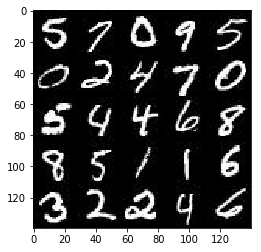

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

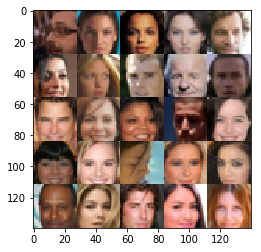

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [38]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.4):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        xavier = tf.contrib.layers.xavier_initializer()
        
        # Input layer is 28x28x3 OR 28*28*1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=xavier)
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob=1-dropout) 
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=1-dropout) 
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=xavier)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=1-dropout) 
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [39]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    training = is_train
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x1024 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [41]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
     # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    steps = 0
    _, width, height, n_channel = data_shape

    
    input_real, input_z, learning_rate = model_inputs(width, height, n_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, n_channel, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                # print('batch_images.shape: ', batch_images.shape)
                # print('batch_z.shape: ', batch_z.shape)

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: lr})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: lr})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 6, input_z, n_channel, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt') 

    return losses
  
                
                

In [32]:
print_every = 10
show_every = 100

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [33]:
from workspace_utils import active_session

Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 3.0046
Epoch 1/2... Discriminator Loss: 0.0966... Generator Loss: 2.9071
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 2.1534
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 2.3369
Epoch 1/2... Discriminator Loss: 2.1299... Generator Loss: 1.2552
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 1.9803
Epoch 1/2... Discriminator Loss: 1.7479... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.7803... Generator Loss: 1.3127


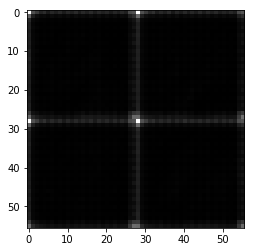

Epoch 1/2... Discriminator Loss: 2.1298... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 1.1289
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.6033... Generator Loss: 0.4922
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 0.3883


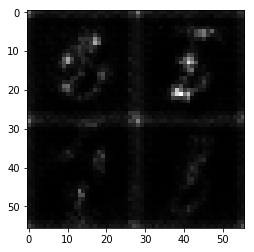

Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 1.3078
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 1.4919
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 1.3994
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 1.1598
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.7650


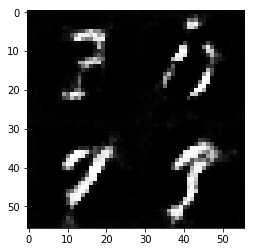

Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 1.5292
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 0.9580
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.8081
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 0.3234
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.6443


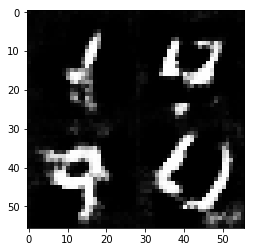

Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 1.0667
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 1.1098


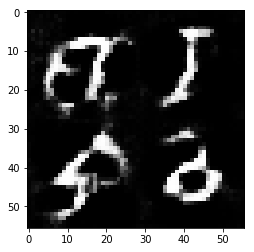

Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.8370
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 1.2688
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.6011


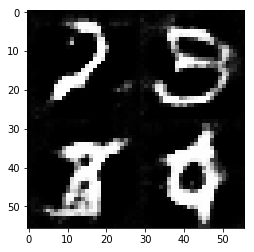

Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 1.1957
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.7027
Epoch 1/2... Discriminator Loss: 1.3633... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.6118


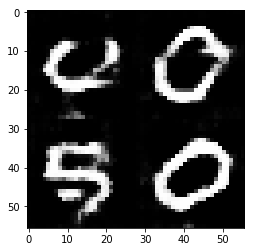

Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.6390
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.3006... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 0.9702
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.8760


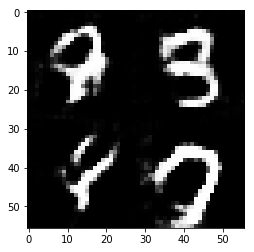

Epoch 1/2... Discriminator Loss: 1.3138... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 1.0334
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.8178


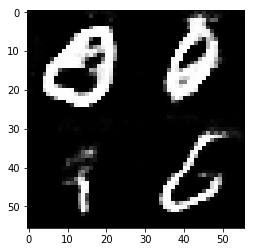

Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 1.2090
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.2517... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 1.1997... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 1.2647
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.9316


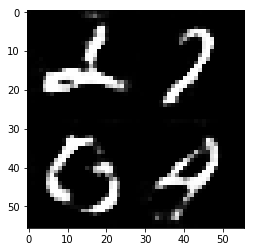

Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 1.1490... Generator Loss: 1.1817
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 1.0848
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.5980
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 0.9166


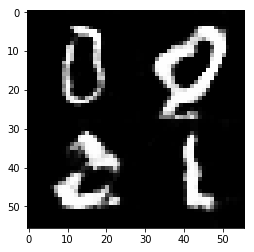

Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 1.2933... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.5641
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.5383
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.5083
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 1.2459... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.6797


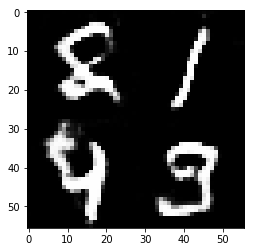

Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.9609
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 0.5737
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 1.5219


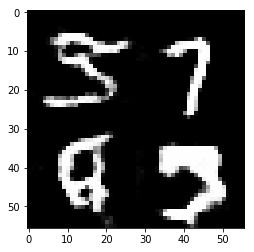

Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.5280
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 1.1099


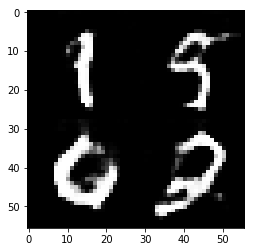

Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.7451
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.3869
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 1.2363
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.7008


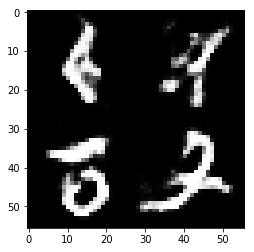

Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.6579
Epoch 2/2... Discriminator Loss: 1.5001... Generator Loss: 0.4734
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.2741... Generator Loss: 1.1237
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.8467
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.5612


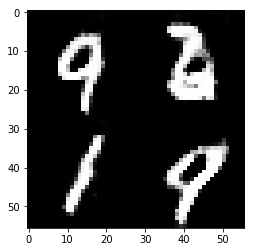

Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 1.4186
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 1.3929
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 1.4063
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.6801


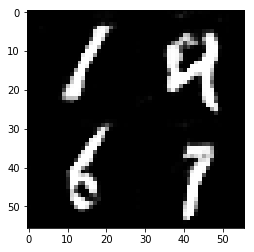

Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.7858
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.8863
Epoch 2/2... Discriminator Loss: 1.5843... Generator Loss: 0.3678
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 1.2474... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 1.5197... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.9210


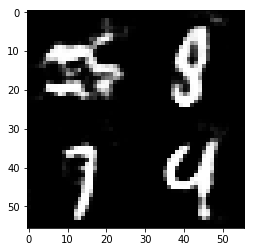

Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 1.3030... Generator Loss: 0.6084
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 1.4141
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2863... Generator Loss: 0.6629


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with active_session():
    with tf.Graph().as_default():
        train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
              mnist_dataset.shape, mnist_dataset.image_mode, alpha)

In [ ]:
# mnist_dataset.shape

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.4852
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 2.1531
Epoch 1/1... Discriminator Loss: 2.0132... Generator Loss: 4.8501
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 3.4302
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 3.2985
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 2.0551
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 2.5330
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 2.4115
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 2.4519


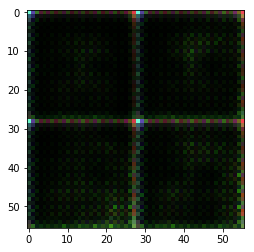

Epoch 1/1... Discriminator Loss: 2.7657... Generator Loss: 0.2523
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.4926
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 3.0915
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 3.2408
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 2.8361
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 3.5894
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 2.9925


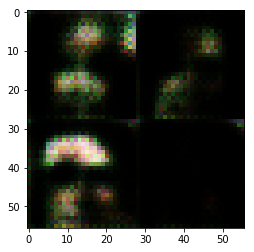

Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 2.2796
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 3.0353
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 4.1464
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 2.1500
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.5891
Epoch 1/1... Discriminator Loss: 1.7702... Generator Loss: 3.6805
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 2.9409
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 2.2831
Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 3.1228
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 2.2339


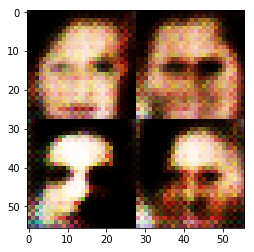

Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 2.5366
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 3.6066
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 2.7276
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 2.1554
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.5918
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 2.7723
Epoch 1/1... Discriminator Loss: 1.8942... Generator Loss: 3.6509
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 1.6332


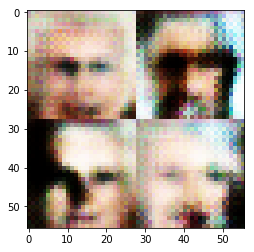

Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 3.0550
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.8537
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 2.2802
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.4209


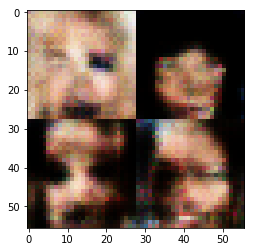

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 2.4393
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 2.0928
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.8887


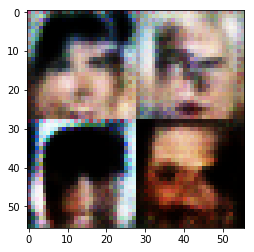

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.8459
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.7227
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.1711
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.2296
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 2.0702


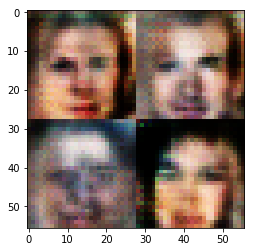

Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.9540... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 1.7450... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.6758
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.7240


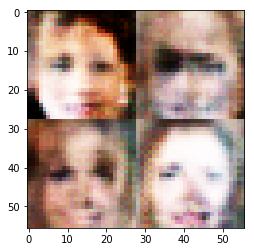

Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.8353... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.8460... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5637


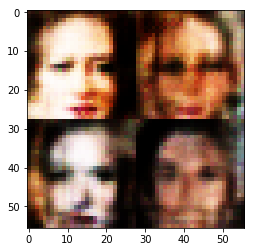

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.8872... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.8510


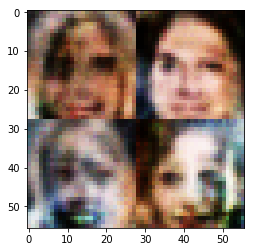

Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.8844... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5713


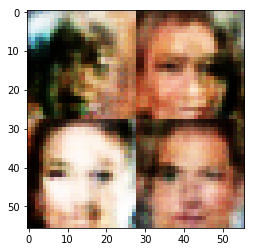

Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.7896... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8280


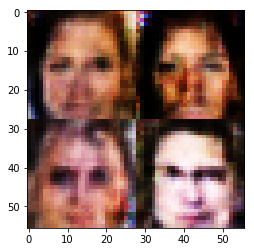

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 2.1285
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 1.4880
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.0786


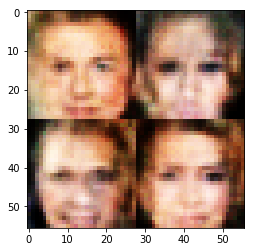

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.1764
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9939


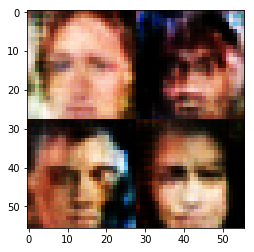

Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.7121


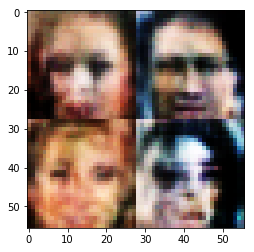

Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.7348... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8928


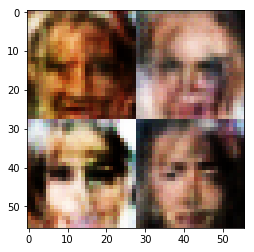

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.3756
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.7341... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.0120


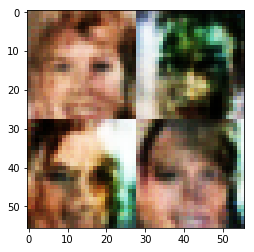

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.3989
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 2.8392
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.0084


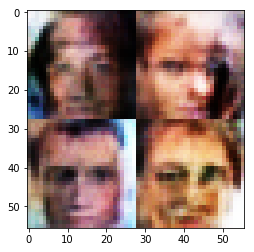

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.6851... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.7645


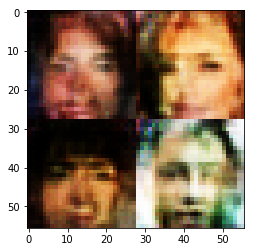

Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.7755


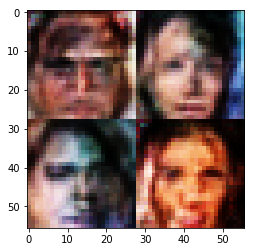

Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.8355


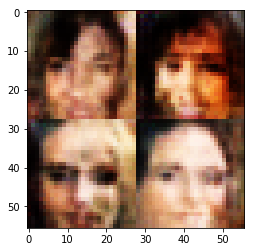

Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 1.1033


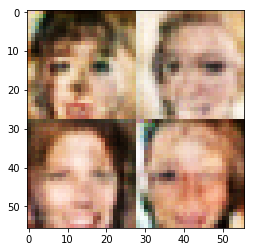

Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.2998
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7168


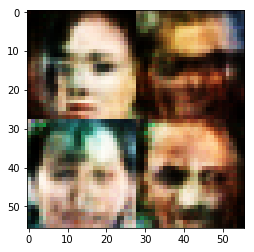

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.7957


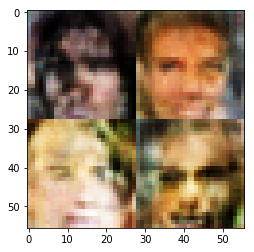

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9623


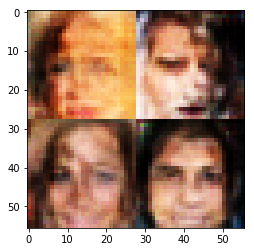

Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7274


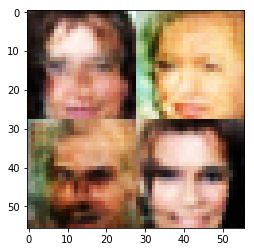

Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5921


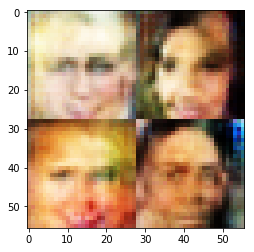

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7605


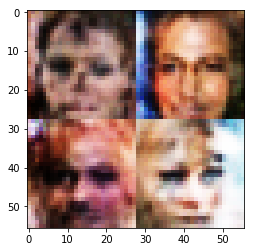

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 1.2635


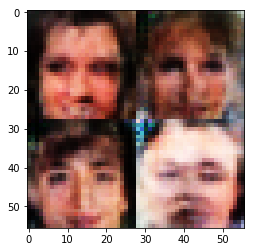

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.4764


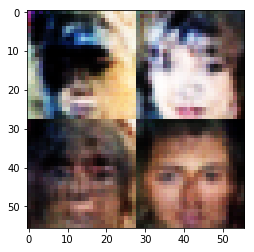

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.9579... Generator Loss: 0.3263
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7868


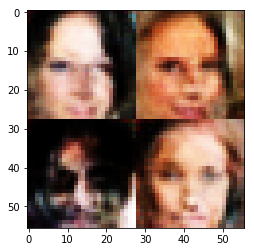

Epoch 1/1... Discriminator Loss: 1.7343... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6158


In [44]:
batch_size = 64
z_dim = 256
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with active_session():
    with tf.Graph().as_default():
        train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
              celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.